In [1]:
import os 
import random
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import spacy
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import gensim.downloader
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import svm
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Concatenate
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import math
from sklearn.metrics import accuracy_score, f1_score

## Read Data

In [2]:
folders_path = '../training'
contents = os.listdir(folders_path)
# for item in contents:
#     print(item)
classes=[]

for item in contents:
    classes.append(item)

In [3]:
def create_data_dict_with_numbers(folders_path, contents):
    data_dict_with_numbers = {}

    for class_name in contents:
        class_path = os.path.join(folders_path, class_name)
        if os.path.isdir(class_path):
            # Initialize dictionary for each class
            data_dict_with_numbers[class_name] = {}
            doc_counter = 1
            for document_name in os.listdir(class_path):
                document_path = os.path.join(class_path, document_name) #each file
                try:
                    with open(document_path, 'r', encoding='utf-8') as file:
                        document_contents = file.read()
                except UnicodeDecodeError:
                    with open(document_path, 'r', encoding='latin') as file:
                        document_contents = file.read()
                    
                # Assign class_name as key and a dictionary with document number as key and document_contents as value
                data_dict_with_numbers[class_name][doc_counter] = document_contents
                doc_counter += 1
    return data_dict_with_numbers


In [4]:
data_dict = create_data_dict_with_numbers(folders_path,contents)

In [5]:
total_documents = 0

for class_name, documents in data_dict.items():
    num_documents_in_class = len(documents)
    print(f"{class_name}' : {num_documents_in_class} ")
    total_documents += num_documents_in_class

print(f"\nTotal number of documents across all classes: {total_documents}")

acq' : 1650 
alum' : 35 
barley' : 37 
bop' : 75 
carcass' : 50 
castor-oil' : 1 
cocoa' : 55 
coconut' : 4 
coconut-oil' : 4 
coffee' : 111 
copper' : 47 
copra-cake' : 2 
corn' : 181 
cotton' : 39 
cotton-oil' : 1 
cpi' : 69 
cpu' : 3 
crude' : 389 
dfl' : 2 
dlr' : 131 
dmk' : 10 
earn' : 2877 
fuel' : 13 
gas' : 37 
gnp' : 101 
gold' : 94 
grain' : 433 
groundnut' : 5 
groundnut-oil' : 1 
heat' : 14 
hog' : 16 
housing' : 16 
income' : 9 
instal-debt' : 5 
interest' : 347 
ipi' : 41 
iron-steel' : 40 
jet' : 4 
jobs' : 46 
l-cattle' : 6 
lead' : 15 
lei' : 12 
lin-oil' : 1 
livestock' : 75 
lumber' : 10 
meal-feed' : 30 
money-fx' : 538 
money-supply' : 138 
naphtha' : 2 
nat-gas' : 75 
nickel' : 8 
nkr' : 1 
nzdlr' : 2 
oat' : 8 
oilseed' : 124 
orange' : 16 
palladium' : 2 
palm-oil' : 30 
palmkernel' : 2 
pet-chem' : 20 
platinum' : 5 
potato' : 3 
propane' : 3 
rand' : 2 
rape-oil' : 5 
rapeseed' : 18 
reserves' : 55 
retail' : 23 
rice' : 35 
rubber' : 37 
rye' : 1 
ship' : 19

In [6]:
# folders have 1 doc

total_documents = 0

for class_name, documents in data_dict.items():
    num_documents_in_class = len(documents)
    if num_documents_in_class==1 :
        print(f"{class_name}' : {num_documents_in_class} ")
    total_documents += num_documents_in_class

castor-oil' : 1 
cotton-oil' : 1 
groundnut-oil' : 1 
lin-oil' : 1 
nkr' : 1 
rye' : 1 
sun-meal' : 1 


### Split Data
#### split the content of a single document into training and testing data if there's only one document in a folder

In [7]:
train_ratio = 0.8
test_ratio = 1 - train_ratio

train_data = {}
test_data = {}

for class_name, documents in data_dict.items():
    num_documents = len(documents)
    if num_documents == 1:  # If only one document in the folder
        document_name, document_content = list(documents.items())[0]
        train_content_size = int(len(document_content) * train_ratio)
        train_content = document_content[:train_content_size]
        test_content = document_content[train_content_size:]

        train_data.setdefault(class_name, {})[document_name] = train_content
        test_data.setdefault(class_name, {})[document_name] = test_content
    else:
        # Shuffle the documents
        shuffled_documents = list(documents.items())
        random.shuffle(shuffled_documents)

        train_index = int(train_ratio * num_documents)

        train_data[class_name] = dict(shuffled_documents[:train_index])
        test_data[class_name] = dict(shuffled_documents[train_index:])

## text preprocessing

In [8]:
def tokenize_documents(data):
    nltk.download('punkt')
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

    tokenized_data_dict = {}

    for class_name, documents in data.items():
        tokenized_documents = {}
        for doc_num, document_content in documents.items():
            tokens = word_tokenize(document_content)
            # Filter out non-alphabetic tokens and stopwords
            filtered_tokens = [token.lower() for token in tokens if token.isalpha() and token.lower() not in stop_words]
            tokenized_documents[doc_num] = filtered_tokens
        tokenized_data_dict[class_name] = tokenized_documents

    return tokenized_data_dict

In [9]:
def normalize_documents(data):
    normalized_data_dict = {}
    for class_name , tokenized_documents in data.items():
        normalized_documents = {}
        for doc_num , tokens in tokenized_documents.items(): 
            normalized_tokens = [token.lower() for token in tokens]
            normalized_documents[doc_num]=normalized_tokens
            normalized_data_dict[class_name]=normalized_documents
            
    return normalized_data_dict

In [10]:
def lemma_documents(data):
    nlp = spacy.load("en_core_web_sm")
    
    lemmatized_data_dict = {}

    for class_name, normalized_documents in data.items():
        lemmatized_documents = {}
        for doc_num, tokens in normalized_documents.items():
            doc = nlp(" ".join(tokens))
            
            lemmatized_tokens = [token.lemma_ for token in doc]
            
            lemmatized_documents[doc_num] = lemmatized_tokens
        
        lemmatized_data_dict[class_name] = lemmatized_documents

    return lemmatized_data_dict

In [11]:
tokenized_train_data = tokenize_documents(train_data)
normalized_train_data = normalize_documents (tokenized_train_data)
lemma_train_data = lemma_documents(normalized_train_data)

lemma_test_data = lemma_documents(normalize_documents (tokenize_documents(test_data)))

[nltk_data] Downloading package punkt to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### compute class weights (for imbalanced dataset)

In [118]:
# class_weight = total_samples / (num_classes * class_frequency)
# more weight to classes with lower frequencies
# class with 100 docs = 109 class with 2 = 5494 (if i have total 1000 docs)

In [12]:
def calculate_class_weights(data):
    
    class_counts = {class_name: len(normalized_documents) for class_name, normalized_documents in data.items()}
    total_samples = sum(class_counts.values())
    class_frequencies = {class_name: count / total_samples for class_name, count in class_counts.items()}
    class_weights = {class_name: total_samples / (len(class_counts) * count) for class_name, count in class_frequencies.items()}
    
    return class_weights

# EDA

### number of times the "negotiate" exist in each class 

In [13]:
def count_word_occurrences_in_classes(folders_path, word):

    results = {}
    
    classes = os.listdir(folders_path)
    
    for class_name in classes:
        class_path = os.path.join(folders_path, class_name)
        
        for document in os.listdir(class_path):
            document_path = os.path.join(class_path, document)  
            with open(document_path, 'r', encoding='utf-8') as file:
                content = file.read()
                
                # Check if the word exists in the document
                if re.search(word, content):
                    # Increment the count for this class
                    if class_name in results:
                        results[class_name] += 1
                    else:
                        results[class_name] = 1
    
    return results

In [14]:
word_pattern = r'\b(negotiate|negotiates|negotiated|negotiating|negotiation)\b'
negotiate_results = count_word_occurrences_in_classes(folders_path, word_pattern)
print(negotiate_results)

{'acq': 65, 'bop': 1, 'cocoa': 5, 'coffee': 12, 'copper': 3, 'corn': 1, 'cotton': 1, 'crude': 12, 'earn': 4, 'gnp': 1, 'grain': 1, 'groundnut': 1, 'interest': 3, 'iron-steel': 2, 'lead': 1, 'lumber': 1, 'money-fx': 5, 'nat-gas': 2, 'oilseed': 3, 'rubber': 3, 'ship': 7, 'soybean': 2, 'sugar': 2, 'tin': 2, 'trade': 26, 'unknown': 58, 'veg-oil': 2, 'wheat': 1, 'zinc': 1}


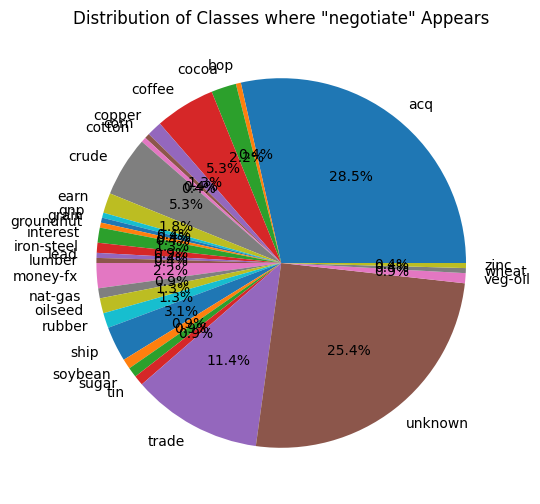

In [15]:
plt.figure(figsize=(6, 6))
plt.pie(negotiate_results.values(), labels=negotiate_results.keys(), autopct='%1.1f%%')
plt.title('Distribution of Classes where "negotiate" Appears')
plt.show()

## it seems like "negotiate" is an important word in "acq" and "unknown" class ,so i can use it as feature to decide that the class is "acq" or "unknown"

In [16]:
word = r'\b(acq|acquisition)\b'
acq_results = count_word_occurrences_in_classes(folders_path, word)
print(acq_results)

{'acq': 296, 'carcass': 1, 'copper': 1, 'corn': 2, 'cotton': 1, 'crude': 5, 'earn': 58, 'grain': 2, 'groundnut': 1, 'lead': 1, 'livestock': 1, 'nat-gas': 2, 'oilseed': 1, 'pet-chem': 1, 'platinum': 1, 'ship': 1, 'sugar': 1, 'trade': 3, 'unknown': 50, 'veg-oil': 1, 'wheat': 1, 'zinc': 1}


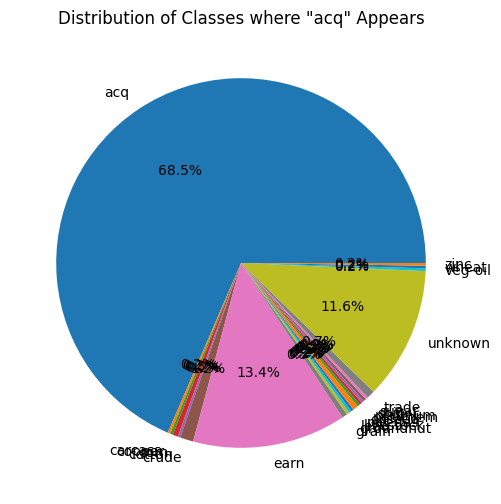

In [17]:
plt.figure(figsize=(6, 6))
plt.pie(acq_results.values(), labels=acq_results.keys(), autopct='%1.1f%%')
plt.title('Distribution of Classes where "acq" Appears')
plt.show()

### we can tell that the existance of the word "acq" is a strong evidence that this is an acquisition-related document 

In [18]:
offer_pattern = r'\b(offer|offers|offered|offering)\b'
offer_results = count_word_occurrences_in_classes(folders_path, offer_pattern)
print(offer_results)

{'acq': 367, 'alum': 3, 'barley': 1, 'bop': 2, 'carcass': 7, 'cocoa': 13, 'coffee': 14, 'copper': 2, 'corn': 19, 'cotton': 5, 'cotton-oil': 1, 'cpi': 2, 'crude': 32, 'dlr': 4, 'earn': 63, 'gas': 1, 'gnp': 3, 'gold': 3, 'grain': 65, 'groundnut': 2, 'hog': 1, 'interest': 32, 'iron-steel': 2, 'jobs': 1, 'l-cattle': 1, 'livestock': 10, 'lumber': 3, 'meal-feed': 3, 'money-fx': 45, 'money-supply': 4, 'nat-gas': 5, 'nickel': 1, 'nzdlr': 1, 'oat': 1, 'oilseed': 11, 'orange': 1, 'palm-oil': 3, 'rand': 1, 'rapeseed': 1, 'reserves': 2, 'rice': 5, 'rubber': 1, 'rye': 1, 'ship': 35, 'sorghum': 2, 'soy-meal': 2, 'soy-oil': 3, 'soybean': 8, 'sugar': 18, 'sun-oil': 1, 'tea': 2, 'tin': 1, 'trade': 17, 'unknown': 422, 'veg-oil': 9, 'wheat': 45, 'yen': 1, 'zinc': 1}


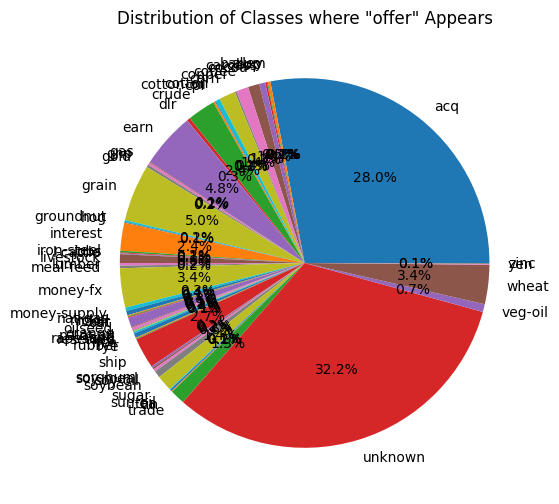

In [19]:
plt.figure(figsize=(6, 6))
plt.pie(offer_results.values(), labels=offer_results.keys(), autopct='%1.1f%%')
plt.title('Distribution of Classes where "offer" Appears')
plt.show()

In [20]:
# there's a huge similarity between (acq) and (unknown)
# so i need to extract features that can help  distinguish them.
# almost  all the information in (acq) is also available for  (unknown) , but having the "acq" word in a document can help me decide that it's (acq)
# i can think that if the document contains "negotiate , offer , acq" then it's class is (acq)
# and if the document contains "negotiate , offer" then it's class is (unknown)

In [21]:
def check_words_in_documents(data, words_to_search):
    word_presence = {}
    for class_name, documents in data.items():
        for doc_num, content in documents.items():
            word_presence[doc_num] = 0  
            for word in words_to_search:
                if word in content:
                    word_presence[doc_num] = 1  
                    break  # No need to continue searching once a word is found
    return word_presence

In [22]:
# feature_words = ["acq", "acquire", "acquires", "acquired", "acquiring", "acquisition", 
#                        "offer", "offers", "offered", "offering",
#                        "negoti", "negotiate", "negotiates", "negotiated", "negotiating", "negotiation"]
first_feature_words = ["acq", "acquire", "acquires", "acquired", "acquiring", "acquisition"]

first_feature = check_words_in_documents(lemma_train_data, first_feature_words)

In [23]:
sec_feature_words = [ "offer", "offers", "offered", "offering"]  
sec_feature = check_words_in_documents(lemma_train_data, sec_feature_words)

In [24]:
third_feature_words = ["negoti", "negotiate", "negotiates", "negotiated", "negotiating", "negotiation"]  
third_feature = check_words_in_documents(lemma_train_data, third_feature_words)

# Naive Bayes Model

### vocabulary set extraction

In [25]:
def extract_vocabulary(data):
    vocabulary_set = set()

    for class_name, documents in data.items():
        for doc_num, tokens in documents.items():
            vocabulary_set.update(tokens)

    return vocabulary_set

In [26]:
vocabulary_set = extract_vocabulary(lemma_train_data)

### function to extract the frequency of each token in each class 

In [27]:
def count_token_occurrences(data):
    token_counts = {}

    for class_name, documents in data.items():
        class_token_counts = {}
        for doc_num, tokens in documents.items():
            for token in tokens:
                if token in class_token_counts:
                    class_token_counts[token] += 1
                else:
                    class_token_counts[token] = 1
        token_counts[class_name] = class_token_counts

    return token_counts

In [28]:
train_token_occurrences = count_token_occurrences(lemma_train_data)
test_token_occurrences = count_token_occurrences(lemma_test_data)

### function to compute the number of tokens in each class

In [29]:
def compute_total_token_counts(token_occurrences):
    total_token_counts = {}

    for class_name, documents in token_occurrences.items():
        total_count = sum(documents.values())
        total_token_counts[class_name] = total_count

    return total_token_counts

In [30]:
train_classes_token_counts = compute_total_token_counts(train_token_occurrences)
test_classes_token_counts = compute_total_token_counts(test_token_occurrences)

### function to compute the occurrences of each token in each class

In [31]:
def count_token_occurrences_in_classes(token_occurrences, vocabulary_set):
    token_occurrences_in_classes = {token: {class_name: 0 for class_name in token_occurrences.keys()} for token in vocabulary_set}

    for class_name, token_counts in token_occurrences.items():
        for token, count in token_counts.items():
            if token in vocabulary_set:
                token_occurrences_in_classes[token][class_name] += count

    return token_occurrences_in_classes


In [32]:
train_token_occurrences_in_classes = count_token_occurrences_in_classes(train_token_occurrences, vocabulary_set)

### prior estimation for each class

In [33]:
def estimate_prior(train_data,total_docs):
    prior_probs = {}

    for class_name, documents in train_data.items():
        num_docs_in_class = len(documents)
        prior_probs[class_name] = num_docs_in_class / total_docs
    
    return prior_probs

In [34]:
prior_probs = estimate_prior(train_data,total_documents)
print("Prior probabilities:", prior_probs)

Prior probabilities: {'acq': 0.11565758345746079, 'alum': 0.0024533426794006836, 'barley': 0.002540962060807851, 'bop': 0.005257162884430036, 'carcass': 0.0035047752562866906, 'castor-oil': 8.761938140716727e-05, 'cocoa': 0.0038552527819153597, 'coconut': 0.0002628581442215018, 'coconut-oil': 0.0002628581442215018, 'coffee': 0.007710505563830719, 'copper': 0.0032419171120651887, 'copra-cake': 8.761938140716727e-05, 'corn': 0.012617190922632086, 'cotton': 0.0027162008236221854, 'cotton-oil': 8.761938140716727e-05, 'cpi': 0.004819065977394199, 'cpu': 0.00017523876281433454, 'crude': 0.02724962761762902, 'dfl': 8.761938140716727e-05, 'dlr': 0.009112415666345396, 'dmk': 0.0007009550512573382, 'earn': 0.20161219661789187, 'fuel': 0.0008761938140716726, 'gas': 0.002540962060807851, 'gnp': 0.007009550512573381, 'gold': 0.006571453605537545, 'grain': 0.030316305966879873, 'groundnut': 0.0003504775256286691, 'groundnut-oil': 8.761938140716727e-05, 'heat': 0.0009638131954788399, 'hog': 0.0010514

### conditional probabilities 

In [35]:
def compute_likelihood(token_occurrences, total_token_counts, vocabulary_set):

    likelihood_probs = {}

    for class_name, token_count in token_occurrences.items():
        class_likelihood = {}
        total_class_tokens = total_token_counts[class_name]
        for token in vocabulary_set:
            token_count_in_class = token_count.get(token, 0)
            likelihood = (token_count_in_class + 1) / (total_class_tokens + len(vocabulary_set))
            class_likelihood[token] = likelihood
        likelihood_probs[class_name] = class_likelihood

    return likelihood_probs

In [36]:
likelihood_probs = compute_likelihood(train_token_occurrences, train_classes_token_counts, vocabulary_set)

### prediction

In [37]:
def predict_NB(document, prior_probs, token_likelihoods):
    scores = {}

    for class_name in prior_probs:
        if prior_probs[class_name] == 0:  # Skip if prior probability is zero
            continue
        scores[class_name] = math.log(prior_probs[class_name])
        for token in document:
            if token in token_likelihoods[class_name]:
               scores[class_name] += math.log(token_likelihoods[class_name][token])

    return scores


In [38]:
correct_predicts = 0
true_labels = []
predicted_labels = []

for class_name, documents in lemma_test_data.items():

    for doc_num, document_tokens in documents.items():

        scores = predict_NB(document_tokens, prior_probs, likelihood_probs)
        predicted_class = max(scores, key=scores.get)
        
        true_labels.append(class_name)
        predicted_labels.append(predicted_class)
        
        
        if predicted_class == class_name:
            correct_predicts += 1

In [39]:
print("Macro-Averaged F1 Score:", f1_score(true_labels, predicted_labels, average="macro"))

Macro-Averaged F1 Score: 0.14375254244114982


In [40]:
lemmatized_data = lemma_documents(normalize_documents(tokenize_documents(data_dict)))

[nltk_data] Downloading package punkt to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
test_data_dict = create_data_dict_with_numbers ( '../test' , os.listdir('../test'))

In [42]:
lemmatized_test_data = lemma_documents(normalize_documents(tokenize_documents(test_data_dict)))

[nltk_data] Downloading package punkt to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rahhal
[nltk_data]     AbuZahra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
test_labels = []

for class_name, documents in lemmatized_test_data.items():
    for doc_num, tokens in documents.items():
         test_labels.append(class_name)

In [44]:
class_weights = calculate_class_weights(lemmatized_data)

# Random Forest (embedding)

In [45]:
word2vec_model = gensim.downloader.load('word2vec-google-news-300')
fasttext_model = gensim.downloader.load('fasttext-wiki-news-subwords-300')
glove_model = gensim.downloader.load('glove-wiki-gigaword-300')

In [48]:
UNK_token = "<UNK>"
UNK_emb_dim = 300

In [49]:
def document_embedding(document, model):
    word_embeddings = []
    unk_embedding = np.random.rand(UNK_emb_dim) 
    
    for word in document:
        if word in model.key_to_index:
            word_embeddings.append(model[word])
        else:
            word_embeddings.append(unk_embedding)  # Use <UNK> embedding for OOV words
    
    if not word_embeddings:
        return None
    
    # Average the word embeddings to get document embedding
    avg_embedding = sum(word_embeddings) / len(word_embeddings)
    
    return avg_embedding

In [50]:
def document_embeddings(data, model):
    document_embeddings_dict = {}
    for class_name, documents in data.items():
        embeddings = {}
        for doc_num, tokens in documents.items():
            embedding = document_embedding(tokens, model)
            if embedding is not None:
                embeddings[doc_num] = embedding
        document_embeddings_dict[class_name] = embeddings
    return document_embeddings_dict

In [51]:
def prepare_data(doc_embeddings):
    X = []
    y = []
    for class_name, embeddings in doc_embeddings.items():
        for doc_num, embedding in embeddings.items():
            X.append(embedding)
            y.append(class_name)
    return X, y

In [119]:
def train_classifier ( X_train , y_train) :
    
    rf_classifier = RandomForestClassifier(n_estimators=250 , random_state=42 , class_weight=class_weights)
    rf_classifier.fit(X_train, y_train)
    
    return rf_classifier

In [53]:
def evaluate_classifier(classifier, X_test, y_test):

    y_pred = classifier.predict(X_test)
    print("Macro-averaged F1 score:", f1_score(y_test, y_pred, average='macro'))  

In [54]:
doc_embeddings_word2vec = document_embeddings(lemmatized_data, word2vec_model)
doc_embeddings_fasttext = document_embeddings(lemmatized_data, fasttext_model)
doc_embeddings_glove = document_embeddings(lemmatized_data, glove_model)

In [55]:
X_word2vec, y_word2vec = prepare_data(doc_embeddings_word2vec)
X_fasttext, y_fasttext = prepare_data(doc_embeddings_fasttext)
X_glove, y_glove = prepare_data(doc_embeddings_glove)

In [56]:
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(X_word2vec, y_word2vec, test_size=0.2, random_state=42)
X_train_fasttext, X_test_fasttext, y_train_fasttext, y_test_fasttext = train_test_split(X_fasttext, y_fasttext, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(X_glove, y_glove, test_size=0.2, random_state=42)

In [57]:
# Initialize Random Forest classifier
classifier_word2vec = train_classifier(X_train_word2vec, y_train_word2vec )
classifier_fasttext = train_classifier(X_train_fasttext, y_train_fasttext )
classifier_glove = train_classifier(X_train_glove, y_train_glove )

In [58]:
# Predict class embeddings for testing data
y_pred_word2vec = evaluate_classifier(classifier_word2vec, X_test_word2vec, y_test_word2vec)
y_pred_fasttext = evaluate_classifier (classifier_fasttext , X_test_fasttext , y_test_fasttext)
y_pred_glove = evaluate_classifier (classifier_glove , X_test_glove , y_test_glove)

Macro-averaged F1 score: 0.1393533385685387
Macro-averaged F1 score: 0.11192167739785741
Macro-averaged F1 score: 0.18346103196572838


In [59]:
# testing

In [63]:
doc_embeddings_word2vec_test = document_embeddings(lemmatized_test_data, word2vec_model)
doc_embeddings_fasttext_test = document_embeddings(lemmatized_test_data, fasttext_model)
doc_embeddings_glove_test = document_embeddings(lemmatized_test_data, glove_model)

In [64]:
X_word2vec_test, y_word2vec_test = prepare_data(doc_embeddings_word2vec_test)
X_fasttext_test, y_fasttext_test = prepare_data(doc_embeddings_fasttext_test)
X_glove_test, y_glove_test = prepare_data(doc_embeddings_glove_test)

In [65]:
# Predict class embeddings for testing data
evaluate_classifier(classifier_word2vec, X_word2vec_test, y_word2vec_test)
evaluate_classifier (classifier_fasttext , X_fasttext_test , y_fasttext_test)
evaluate_classifier (classifier_glove , X_glove_test , y_glove_test)

Macro-averaged F1 score: 0.1620048652296069
Macro-averaged F1 score: 0.13139117492919597
Macro-averaged F1 score: 0.21512781466610495


# Random Forest ( TF-IDF )

In [66]:
def tfidf_representation(data, tfidf_vectorizer_RF=None):
    # Create a list to store documents
    documents = []
    class_labels = []
    
    for class_name, lemmatized_documents in data.items():
        for doc_num, lemmatized_tokens in lemmatized_documents.items():
            # Join the lemmatized tokens back into a single string
            document_text = " ".join(lemmatized_tokens)
            documents.append(document_text)
            class_labels.append(class_name)
            
    if tfidf_vectorizer_RF is None:
        tfidf_vectorizer_RF = TfidfVectorizer()
    
    # Compute TF-IDF vectors for the documents
    tfidf_vectors = tfidf_vectorizer_RF.fit_transform(documents)
    
    # Convert the sparse TF-IDF matrix to a dense array
    tfidf_matrix = tfidf_vectors.toarray()
    
    return tfidf_matrix, class_labels , tfidf_vectorizer_RF


In [67]:
tfidf_matrix_RF, class_labels_RF,tfidf_vectorizer_RF  = tfidf_representation(lemmatized_data)

In [68]:
X_train_TF_RF, X_test_TF_RF, y_train_TF_RF, y_test_TF_RF = train_test_split(tfidf_matrix_RF, class_labels_RF, test_size=0.2, random_state=42)

In [69]:
RF_TF_classifier = RandomForestClassifier(n_estimators=100, random_state=42 ,class_weight=class_weights)

In [70]:
RF_TF_classifier.fit(X_train_TF_RF, y_train_TF_RF)

RandomForestClassifier(class_weight={'acq': 867.5096170496171,
                                     'alum': 40896.88194662481,
                                     'barley': 38686.23967923968,
                                     'bop': 19085.211575091576,
                                     'carcass': 28627.81736263736,
                                     'castor-oil': 1431390.868131868,
                                     'cocoa': 26025.288511488514,
                                     'coconut': 357847.717032967,
                                     'coconut-oil': 357847.717032967,
                                     'coffee': 12895.413226413228,
                                     'copper': 30455.12485386954,
                                     'copra-cake':...
                                     'crude': 3679.668041470098,
                                     'dfl': 715695.434065934,
                                     'dlr': 10926.647848334871,
                                     'dmk': 143139.08681318682,
                                     'earn': 497.52897745285657,
                                     'fuel': 110106.98985629754,
                                     'gas': 38686.23967923968,
                                     'gnp': 14172.186813186812,
                                     'gold': 15227.56242693477,
                                     'grain': 3305.752582290688,
                                     'groundnut': 286278.17362637364,
                                     'groundnut-oil': 1431390.868131868,
                                     'heat': 102242.20486656201, ...},
                       random_state=42)

In [71]:
y_pred_TF_RF = RF_TF_classifier.predict(X_test_TF_RF)

In [83]:
print("Accuracy with TF IDF:", accuracy_score(y_test_TF_RF, y_pred_TF_RF))

print("Random Forest Macro F-score with TF IDF:", f1_score(y_test_TF_RF, y_pred_TF_RF, average='macro'))

Accuracy with TF IDF: 0.6618484450284713
Random Forest Macro F-score with TF IDF: 0.2325186621994876


In [73]:
# testing

In [74]:
testing_documents = []
testing_labels=[]
for class_name, lemmatized_documents in lemmatized_test_data.items():
    for doc_num, lemmatized_tokens in lemmatized_documents.items():
        # Join the lemmatized tokens back into a single string
        document_text = " ".join(lemmatized_tokens)
        testing_documents.append(document_text)
        testing_labels.append(class_name)

In [75]:
tfidf_matrix_RF_testing = tfidf_vectorizer_RF.transform ( testing_documents )

In [76]:
y_pred_TF_RF_testing = RF_TF_classifier.predict(tfidf_matrix_RF_testing)

In [84]:
print("Random Forest Macro F-score with TF IDF testing:", f1_score(testing_labels, y_pred_TF_RF_testing, average='macro'))

Random Forest Macro F-score with TF IDF testing: 0.31770688889925497


# KNN

In [78]:
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_TF_RF,y_train_TF_RF)

KNeighborsClassifier()

In [79]:
knn_classifier_predictions = knn_classifier.predict(X_test_TF_RF)

In [80]:
print(" KNN Macro F-score with TF IDF:", f1_score(y_test_TF_RF, knn_classifier_predictions, average='macro'))

Macro F-score with TF IDF: 0.2694855781765116


In [81]:
print("KNN Macro F-score with TF IDF testing:", f1_score(testing_labels, knn_classifier.predict(tfidf_matrix_RF_testing), average='macro'))

KNN Macro F-score with TF IDF testing: 0.2959888683250385


# Ensemble using KNN, decision tree classifier,Random forest, and naive Bayes models.

In [85]:
X_tfidf_ensemble, labels_ensemble, tfidf_vectorizer_ensemble = tfidf_representation(lemmatized_data)

In [86]:
X_tfidf_ensemble, labels_ensemble, tfidf_vectorizer_ensemble = tfidf_representation(lemmatized_data)

In [87]:
X_train_ensemble, X_test_ensemble, y_train_ensemble, y_test_ensemble = train_test_split(X_tfidf_ensemble, labels_ensemble, test_size=0.2, random_state=42)

In [88]:
# Train KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_ensemble, y_train_ensemble)


# Train decision tree classifier
decision_tree_model = DecisionTreeClassifier(class_weight=class_weights)
decision_tree_model.fit(X_train_ensemble, y_train_ensemble)

# Train random forest classifier
RF_ensemble_classifier = RandomForestClassifier(n_estimators=100, random_state=42,class_weight=class_weights)
RF_ensemble_classifier.fit(X_train_ensemble, y_train_ensemble)

RandomForestClassifier(class_weight={'acq': 867.5096170496171,
                                     'alum': 40896.88194662481,
                                     'barley': 38686.23967923968,
                                     'bop': 19085.211575091576,
                                     'carcass': 28627.81736263736,
                                     'castor-oil': 1431390.868131868,
                                     'cocoa': 26025.288511488514,
                                     'coconut': 357847.717032967,
                                     'coconut-oil': 357847.717032967,
                                     'coffee': 12895.413226413228,
                                     'copper': 30455.12485386954,
                                     'copra-cake':...
                                     'crude': 3679.668041470098,
                                     'dfl': 715695.434065934,
                                     'dlr': 10926.647848334871,
                                     'dmk': 143139.08681318682,
                                     'earn': 497.52897745285657,
                                     'fuel': 110106.98985629754,
                                     'gas': 38686.23967923968,
                                     'gnp': 14172.186813186812,
                                     'gold': 15227.56242693477,
                                     'grain': 3305.752582290688,
                                     'groundnut': 286278.17362637364,
                                     'groundnut-oil': 1431390.868131868,
                                     'heat': 102242.20486656201, ...},
                       random_state=42)

In [89]:
# Generate predictions from logistic regression model
knn_model_predictions = knn_model.predict(X_test_ensemble)

# Generate predictions from decision tree classifier
decision_tree_predictions = decision_tree_model.predict(X_test_ensemble)

# Generate predictions from random forest classifier
random_forest_predictions = RF_ensemble_classifier.predict(X_test_ensemble)

In [90]:
import scipy.sparse as sp

def reverse_tfidf(X_tfidf, tfidf_vectorizer):
    reverse_mapping = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}
    if sp.issparse(X_tfidf):
        return [' '.join([reverse_mapping.get(idx) for idx in row.indices]) for row in X_tfidf]
    else:
        return [' '.join([reverse_mapping.get(idx) for idx, value in enumerate(row) if value != 0]) for row in X_tfidf]

In [91]:
X_test_text_ensemble = reverse_tfidf(X_test_ensemble, tfidf_vectorizer_ensemble)

In [92]:
nb_predictions = [predict_NB(doc.split(), prior_probs, likelihood_probs) for doc in X_test_text_ensemble]

In [93]:
nb_predicted_classes = [max(pred, key=pred.get) for pred in nb_predictions]

In [94]:
# Perform majority voting

ensemble_predictions_majority = np.array([
    max(set([nb_pred, knn_pred, dt_pred, rf_pred]), key=[nb_pred, knn_pred, dt_pred, rf_pred].count)
    for nb_pred, knn_pred, dt_pred, rf_pred in zip(nb_predicted_classes, knn_model_predictions, decision_tree_predictions, random_forest_predictions)
])

In [95]:
print(" Ensemble Macro-averaged F1 score with TF IDF:", f1_score(y_test_ensemble, ensemble_predictions_majority, average='macro'))

 Ensemble Macro-averaged F1 score with TF IDF: 0.25631971648899254


In [96]:
lemmatized_testing_texts = []

for class_name, documents in lemmatized_test_data.items():
    for doc_num, tokens in documents.items():
         lemmatized_testing_texts.append(" ".join(tokens))

In [97]:
X_tfidf_ensemble_testing = tfidf_vectorizer_ensemble.transform(lemmatized_testing_texts)

In [98]:
testing_knn_predictions = knn_model.predict(X_tfidf_ensemble_testing)
testing_decision_tree_predictions = decision_tree_model.predict(X_tfidf_ensemble_testing)
testing_random_forest_predictions = RF_ensemble_classifier.predict(X_tfidf_ensemble_testing)

In [99]:
testing_nb_predictions = [predict_NB(doc.split(), prior_probs, likelihood_probs) for doc in lemmatized_testing_texts]

In [100]:
nb_predicted_classes_ensemble_testing = [max(pred, key=pred.get) for pred in testing_nb_predictions]

In [101]:
# Perform majority voting
ensemble_predictions_majority_testing = np.array([
    max(set([nb_pred, knn_pred, dt_pred, rf_pred]), key=[nb_pred, knn_pred, dt_pred, rf_pred].count)
    for nb_pred, knn_pred, dt_pred, rf_pred in zip(nb_predicted_classes_ensemble_testing, testing_knn_predictions, testing_decision_tree_predictions, testing_random_forest_predictions)
])

In [102]:
print("Ensemble Macro-averaged F1 score with TF IDF testing :", f1_score(test_labels, ensemble_predictions_majority_testing, average='macro'))

Ensemble Macro-averaged F1 score with TF IDF testing : 0.34474914057844436


# SVM (embedding)

In [ ]:
# Define the parameter grid
param_grid_SVM = {
    'kernel': ['poly', 'rbf'],
    'C': [0.1, 1, 10], 
    'gamma': ['scale', 'auto']  
}


In [ ]:
# # Initialize the SVM classifier
# svm_classifier_model = SVC(class_weight=class_weights)

In [ ]:
# # Perform grid search
# svm_grid_search = GridSearchCV(estimator=svm_classifier_model, param_grid=param_grid_SVM, cv=5, scoring='f1_macro')
# svm_grid_search.fit(X_train_glove, y_train_glove)

In [ ]:
# # Get the best hyperparameters
# svm_best_params = svm_grid_search.best_params_
# print("Best Hyperparameters:", svm_best_params)

In [103]:
svm_classifier = svm.SVC(C=10, gamma='scale', kernel='poly',class_weight=class_weights)
svm_classifier.fit(X_train_glove, y_train_glove)

SVC(C=10,
    class_weight={'acq': 867.5096170496171, 'alum': 40896.88194662481,
                  'barley': 38686.23967923968, 'bop': 19085.211575091576,
                  'carcass': 28627.81736263736, 'castor-oil': 1431390.868131868,
                  'cocoa': 26025.288511488514, 'coconut': 357847.717032967,
                  'coconut-oil': 357847.717032967, 'coffee': 12895.413226413228,
                  'copper': 30455.12485386954, 'copra-cake': 715695.4340659...
                  'cpu': 477130.28937728936, 'crude': 3679.668041470098,
                  'dfl': 715695.434065934, 'dlr': 10926.647848334871,
                  'dmk': 143139.08681318682, 'earn': 497.52897745285657,
                  'fuel': 110106.98985629754, 'gas': 38686.23967923968,
                  'gnp': 14172.186813186812, 'gold': 15227.56242693477,
                  'grain': 3305.752582290688, 'groundnut': 286278.17362637364,
                  'groundnut-oil': 1431390.868131868,
                  'heat': 102242.20486656201, ...},
    kernel='poly')

In [104]:
y_pred_svm = svm_classifier.predict(X_test_glove)

In [105]:
print(" SVM Macro F1 score:", f1_score(y_test_glove, y_pred_svm, average='macro'))

 SVM Macro F1 score: 0.2472668330843564


In [106]:
y_pred_svm_testing = svm_classifier.predict(X_glove_test)
print(" SVM Macro F1 score:", f1_score(y_glove_test, y_pred_svm_testing, average='macro'))

 SVM Macro F1 score: 0.3126754698153731


# RNN ( LSTM )

In [107]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts([doc_content for class_docs in data_dict.values() for doc_content in class_docs.values()])

In [108]:
tokenized_sequences = []
class_list = []

for class_name, class_docs in data_dict.items():
    for doc_num, doc_content in class_docs.items():
        doc_tokens = tokenizer.texts_to_sequences([doc_content])[0]
        tokenized_sequences.append(doc_tokens)
        class_list.append(class_name)

In [109]:
RNN_label_encoder = LabelEncoder()
encoded_labels = RNN_label_encoder.fit_transform(class_list)

In [110]:
avg_length = sum(len(seq) for seq in tokenized_sequences) // len(tokenized_sequences)
padded_sequences = pad_sequences(tokenized_sequences, maxlen=avg_length)

In [111]:
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

In [112]:
print("Shape of padded sequences:", padded_sequences.shape)
print("Shape of encoded labels:", encoded_labels.shape)

Shape of padded sequences: (11413, 157)
Shape of encoded labels: (11413,)


In [113]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(padded_sequences, encoded_labels, test_size=0.2, random_state=42)

In [114]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    tf.keras.layers.LSTM(64),  
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(encoded_labels), activation='softmax')  
])

In [115]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [116]:
history = model.fit(X_train_rnn, y_train_rnn, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 28s 102ms/step - accuracy: 0.2368 - loss: 4.9769 - val_accuracy: 0.2618 - val_loss: 2.8243
Epoch 2/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 27s 103ms/step - accuracy: 0.2608 - loss: 2.7581 - val_accuracy: 0.3341 - val_loss: 2.5918
Epoch 3/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.3333 - loss: 2.4323 - val_accuracy: 0.3921 - val_loss: 2.1999
Epoch 4/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.4395 - loss: 2.0363 - val_accuracy: 0.4765 - val_loss: 1.9242
Epoch 5/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.5766 - loss: 1.6230 - val_accuracy: 0.5685 - val_loss: 1.6976
Epoch 6/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.6432 - loss: 1.3402 - val_accuracy: 0.6002 - val_loss: 1.5933
Epoch 7/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 97ms/step - accuracy: 0.6840 - loss: 1.1055 - val_accuracy: 0.6134 - val_loss: 1.5571
Epoch 8/10
257/257 ━━━━━━━━━━━━━━━━━━━━ 25s 98ms/step - accuracy: 0.7348 - loss: 0.9162

In [117]:
y_pred_rnn = model.predict(X_test_rnn)
y_pred_classes = np.argmax(y_pred_rnn, axis=1)

print("Macro F1 Score:", f1_score(y_test_rnn, y_pred_classes, average='macro'))

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Macro F1 Score: 0.11927259756662931
